In [1]:
import numpy as np
import matplotlib as plt
from numba import njit
from numpy.typing import NDArray
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from util import normalize_values, ideal_point_method, linear_convolution

In [2]:
@njit
def get_system_size(n: int, N: int):
    return n + N + 1

In [3]:
@njit
def get_transition_intensity_matrix(
    n: int, 
    N: int,
    lambda_val: float,
    mu: float,
    gamma: float
) -> NDArray:
  size = get_system_size(n, N)
  transition_intensity_matrix = np.zeros((size, size))

  for i in range(size):
    for j in range(size):
        if i == j:
            continue

        if i != N + n:
            value = lambda_val
            transition_intensity_matrix[i][i + 1] = value
            
        if i > 0 and i <= n:
            value = i * mu
            transition_intensity_matrix[i][i - 1] = value
        elif i > n:
            value = n * mu + (i - n) * gamma
            transition_intensity_matrix[i][i - 1] = value
    
  for i in range(size):
    transition_intensity_matrix[i][i] = - np.sum(transition_intensity_matrix[i])
    
  return transition_intensity_matrix

In [4]:
def solve_global_balance_equation(
    Q: NDArray[NDArray[float]],
    n: int,
    N: int
) -> NDArray[float]:
    size = get_system_size(n, N)

    system = np.transpose(Q)
    norm_equation = np.ones(size)
    system = np.delete(system, 0, axis=0)
    system = np.vstack([system, norm_equation])

    b = np.zeros(size)
    b[-1] = 1

    q = np.linalg.solve(system, b)

    return q

In [5]:
@njit(fastmath=True)
def get_num_is_system(
    q: NDArray[float],
    n: int,
    N: int,
) -> float:
    num_in_system = 0
    for i in range(n + N + 1):
        num_in_system += i * q[i]
            
    return num_in_system

@njit(fastmath=True)
def get_probability_of_loss(
    q: NDArray[float],
    n: int,
    N: int,
    lambda_val: float,
    gamma: float,
) -> float:    
    num_in_queue = 0
    for i in range(1, N + 1):
        num_in_queue += i * q[i + n]
    
    reject_probability = q[N + n]
    probability = ((gamma / lambda_val) * num_in_queue) + reject_probability
    
    return probability

In [6]:
def get_statistics(
    n: int,
    N: int,
    lambda_val: float,
    mu: float,
    gamma: float
) -> (float, float):
    Q = get_transition_intensity_matrix(n, N, lambda_val, mu, gamma)
    q = solve_global_balance_equation(Q, n, N)
    
    probability_of_loss = get_probability_of_loss(q, 1, N, lambda_val / n, gamma)
    num_in_system = get_num_is_system(q, 1, N)

    response_time = num_in_system / (lambda_val * (1 - probability_of_loss))

    return response_time, probability_of_loss

In [7]:
p = 0.95
lambda_val = 1 / 0.299
mu = 1 / (37.69 * p)
gamma = 1 / 510

In [8]:
MAX_SERVERS = 200
MIN_SERVERS = 1

max_size_queue = 100

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)

response_times = np.empty(0)
loss_probabilities = np.empty(0)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    response_time, probability_of_loss = get_statistics(
        1,
        max_size_queue,
        lambda_val / i,
        mu,
        gamma
    )
    response_times = np.append(response_times, response_time)
    loss_probabilities = np.append(loss_probabilities, probability_of_loss)
    

with open('analytical_random_response_times.npy', 'wb') as f:
    np.save(f, response_times)

with open('analytical_random_probability_of_loss.npy', 'wb') as f:
    np.save(f, loss_probabilities)

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
response_times = np.load('analytical_random_response_times.npy')
loss_probabilities = np.load('analytical_random_probability_of_loss.npy')

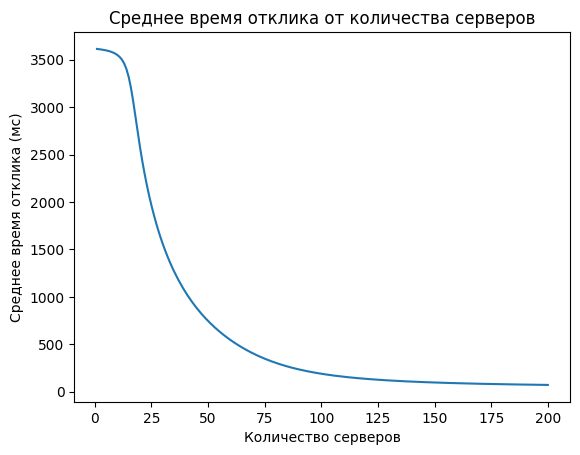

In [10]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Среднее время отклика (мс)')
plt.xlabel('Количество серверов')
plt.title(title)

plt.plot(servers_num, response_times)

plt.show()

In [11]:
normalized_response_times = normalize_values(response_times)
normalized_servers_num = normalize_values(servers_num)

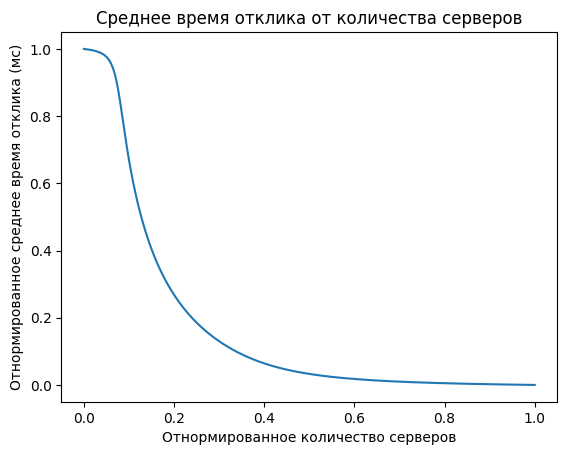

In [12]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Отнормированное среднее время отклика (мс)')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, normalized_response_times)

plt.show()

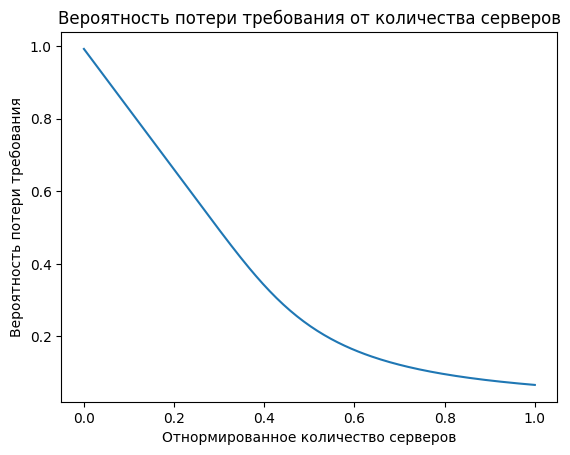

In [13]:
title = 'Вероятность потери требования от количества серверов'
        
plt.ylabel('Вероятность потери требования')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, loss_probabilities)

plt.show()

In [14]:
ideal_point = (0, 0, 0)
ideal_point_method_result = ideal_point_method(normalized_servers_num, normalized_response_times, loss_probabilities, (0, 0, 0))

optimal_index = np.argmin(ideal_point_method_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

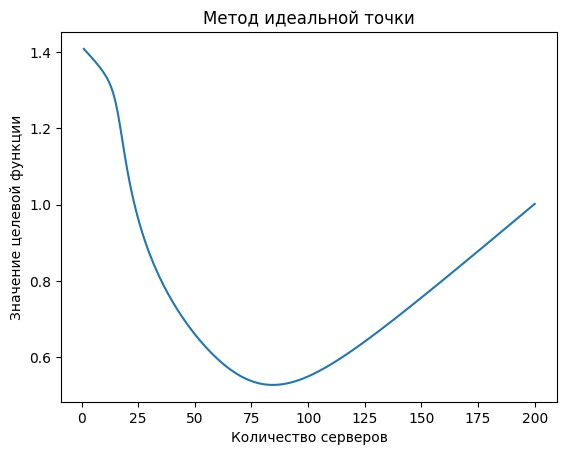

In [15]:
plt.title('Метод идеальной точки')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, ideal_point_method_result)

plt.show()

In [16]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 84
Время отклика: 273.7295111647478
Вероятность потери заявки: 0.3181125456772365


In [17]:
weights = (0.1, 0.6, 0.3)

linear_convolution_result = linear_convolution(normalized_servers_num, normalized_response_times, loss_probabilities, weights)

optimal_index = np.argmin(linear_convolution_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

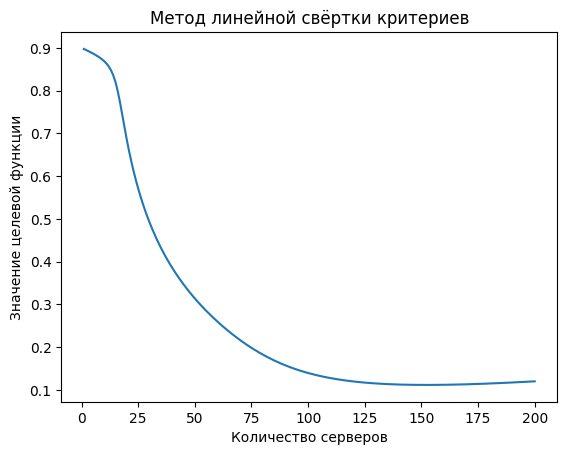

In [18]:
plt.title('Метод линейной свёртки критериев')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, linear_convolution_result)

plt.show()

In [19]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Среднее время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 152
Среднее время отклика: 95.83957505248169
Вероятность потери заявки: 0.10531664277605596
